# first tests for optimization

In [1]:
import sys
sys.path.insert(0, "../source/")

from FOM_advectiondiffusion import FOM_advectiondiffusion
from FOM_advectiondiffusion_steadystate import FOM_advectiondiffusion_steadystate
from Drone import Drone
from Parameter import Parameter
from Brain import Brain
from NoiseModel import NoiseModel
from Prior import Prior

import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import math
import scipy.stats as stats

In [2]:
tStart_notebook = time.time()

## User settings

In [3]:
meshDim = 50 
# meshDim=50 is probably too coarse but for writing the code it should suffice, I'm impatient

n_para = 2
n_search = 30

eval_mode = "point-eval" # because it's faster for testing code

## Setup

In [4]:
fom = FOM_advectiondiffusion_steadystate(meshDim=meshDim)
fom_transient = FOM_advectiondiffusion(meshDim=meshDim, dt=0.04, final_time=4)

In [5]:
para_true = np.ones((n_para,))
m = fom.assemble_forcing(para=para_true)
sol_transient, grid_t = fom.implicit_Euler(m_init=m, dt=0.04, final_time=4)
sol_steadystate = fom.solve_steady(forcing=m)

In [6]:
# set default flying parameters
flying_parameters = {
                "radius" : 0.25,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.2 # 0.3
            }

drone = Drone(fom, grid_t=grid_t, flying_parameters=flying_parameters, eval_mode=eval_mode)
pos, __ = drone.get_trajectory(grid_t=grid_t, flying_parameters=flying_parameters)

In [7]:
prior = Prior(covar = np.eye(n_para), mean = np.zeros((n_para,)))

noise_model = NoiseModel(grid_t=grid_t, c_scaling=1e+3, c_diffusion = 0.01)
noise_model_transient = NoiseModel(grid_t=grid_t, c_scaling=1e+1, c_diffusion = 0.01)

brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)
brain_transient = Brain(fom=fom_transient, drone=drone, prior=prior, noise_model=noise_model_transient)

In [8]:
print("just for testing:")

post_steadystate = brain.compute_posterior()
print("steady-state mean: ", post_steadystate.mean)

post_transient = brain_transient.compute_posterior()
print("transient mean:    ", post_transient.mean)

print("steady-state:")
print("A-OED:", brain.eval_utility(post_steadystate, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_steadystate, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_steadystate, oed_mode="E"), "\n")

print("transient:")
print("A-OED:", brain.eval_utility(post_transient, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_transient, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_transient, oed_mode="E"), "\n")

just for testing:
steady-state mean:  None
transient mean:     None
steady-state:
A-OED: 0.005000251517179809
D-OED: 4.370807168640297e-06
E-OED: 0.003871191635973063 

transient:
A-OED: 1.0891843271869655
D-OED: 0.14802254348072885
E-OED: 0.9300244937977635 



## grid search

### radius

In [9]:
radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4]))
radius_max = la.norm(np.array([0, 0.55])/2)

search_grid = np.linspace(radius_min, radius_max, n_search)
util_steadystate = np.zeros((n_search, 3))
util_transient = np.zeros((n_search, 3))

for i in range(n_search):
    print("iteration {} / {}".format(i+1, n_search))
    
    flying_parameters = {
                "radius" : search_grid[i],
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.2 # 0.3
            }

    drone.set_default_flying_parameters(flying_parameters)
    
    post_steadystate = brain.compute_posterior()
    post_transient = brain_transient.compute_posterior()
    
    util_steadystate[i, 0] = brain.eval_utility(post_steadystate, oed_mode="A")
    util_steadystate[i, 1] = brain.eval_utility(post_steadystate, oed_mode="D")
    util_steadystate[i, 2] = brain.eval_utility(post_steadystate, oed_mode="E")
    
    util_transient[i, 0] = brain.eval_utility(post_transient, oed_mode="A")
    util_transient[i, 1] = brain.eval_utility(post_transient, oed_mode="D")
    util_transient[i, 2] = brain.eval_utility(post_transient, oed_mode="E")

iteration 1 / 30
iteration 2 / 30
iteration 3 / 30
iteration 4 / 30
iteration 5 / 30
iteration 6 / 30
iteration 7 / 30
iteration 8 / 30
iteration 9 / 30
iteration 10 / 30
iteration 11 / 30
iteration 12 / 30
iteration 13 / 30
iteration 14 / 30
iteration 15 / 30
iteration 16 / 30
iteration 17 / 30
iteration 18 / 30
iteration 19 / 30
iteration 20 / 30
iteration 21 / 30
iteration 22 / 30
iteration 23 / 30
iteration 24 / 30
iteration 25 / 30
iteration 26 / 30
iteration 27 / 30
iteration 28 / 30
iteration 29 / 30
iteration 30 / 30


Optimal radius:
A-OED, steady-state: 0.275
A-OED, transient:    0.275
D-OED, steady-state: 0.275
D-OED, transient:    0.23096886340883724
E-OED, steady-state: 0.275
E-OED, transient:    0.275


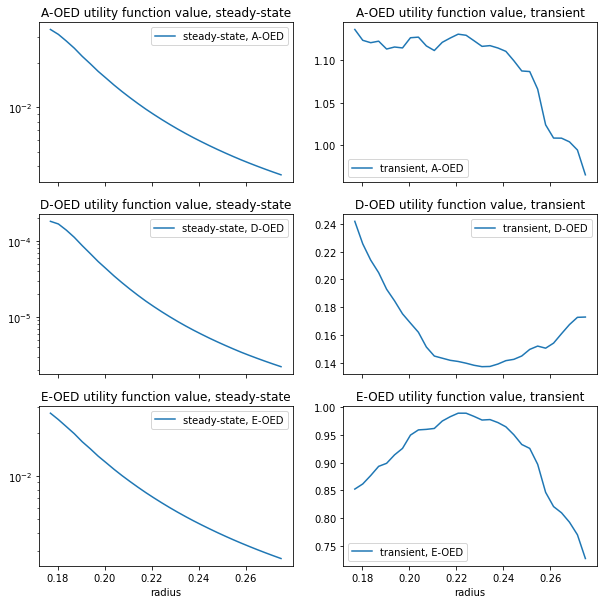

In [10]:
util_names = ["A", "D", "E"]
fig, axs = plt.subplots(3, 2, sharex = True, figsize = (10, 10))

for i in range(3):
    axs[i, 0].semilogy(search_grid, util_steadystate[:, i], label="steady-state, {}-OED".format(util_names[i]))
    axs[i, 1].plot(search_grid, util_transient[:, i], label="transient, {}-OED".format(util_names[i]))
    
    axs[i, 0].legend()
    axs[i, 0].set_title("{}-OED utility function value, steady-state".format(util_names[i]))
    
    axs[i, 1].legend()
    axs[i, 1].set_title("{}-OED utility function value, transient".format(util_names[i]))
    
axs[-1, 0].set_xlabel("radius")
axs[-1, 1].set_xlabel("radius")

print("Optimal radius:")
print("A-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 0])])
print("A-OED, transient:   ", search_grid[np.argmin(util_transient[:, 0])])

print("D-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 1])])
print("D-OED, transient:   ", search_grid[np.argmin(util_transient[:, 1])])

print("E-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 2])])
print("E-OED, transient:   ", search_grid[np.argmin(util_transient[:, 2])])

### speed

In [11]:
radius = (radius_min + radius_max)/2
round_trip_time_min = 1
round_trip_time_max = 8

speed_min = (2 * np.pi * radius) / round_trip_time_max
speed_max = (2 * np.pi * radius) / round_trip_time_min

search_grid = np.linspace(speed_min, speed_max, n_search)
util_steadystate = np.zeros((n_search, 3))
util_transient = np.zeros((n_search, 3))

for i in range(n_search):
    print("iteration {} / {}".format(i+1, n_search))
    
    flying_parameters = {
                "radius" : radius,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : search_grid[i]
            }

    drone.set_default_flying_parameters(flying_parameters)
    
    post_steadystate = brain.compute_posterior()
    post_transient = brain_transient.compute_posterior()
    
    util_steadystate[i, 0] = brain.eval_utility(post_steadystate, oed_mode="A")
    util_steadystate[i, 1] = brain.eval_utility(post_steadystate, oed_mode="D")
    util_steadystate[i, 2] = brain.eval_utility(post_steadystate, oed_mode="E")
    
    util_transient[i, 0] = brain.eval_utility(post_transient, oed_mode="A")
    util_transient[i, 1] = brain.eval_utility(post_transient, oed_mode="D")
    util_transient[i, 2] = brain.eval_utility(post_transient, oed_mode="E")

iteration 1 / 30
iteration 2 / 30
iteration 3 / 30
iteration 4 / 30
iteration 5 / 30
iteration 6 / 30
iteration 7 / 30
iteration 8 / 30
iteration 9 / 30
iteration 10 / 30
iteration 11 / 30
iteration 12 / 30
iteration 13 / 30
iteration 14 / 30
iteration 15 / 30
iteration 16 / 30
iteration 17 / 30
iteration 18 / 30
iteration 19 / 30
iteration 20 / 30
iteration 21 / 30
iteration 22 / 30
iteration 23 / 30
iteration 24 / 30
iteration 25 / 30
iteration 26 / 30
iteration 27 / 30
iteration 28 / 30
iteration 29 / 30
iteration 30 / 30


Optimal speed:
A-OED, steady-state: 1.4192983470069889
A-OED, transient:    1.4192983470069889
D-OED, steady-state: 1.4192983470069889
D-OED, transient:    1.3764746899852263
E-OED, steady-state: 1.4192983470069889
E-OED, transient:    1.4192983470069889


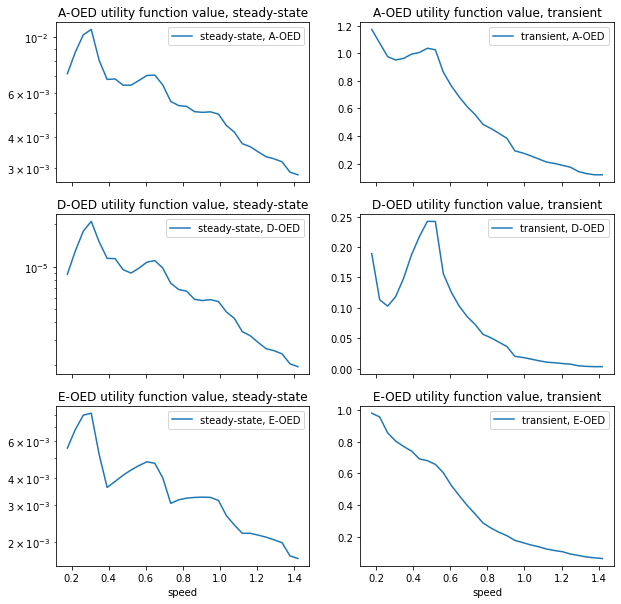

In [12]:
util_names = ["A", "D", "E"]
fig, axs = plt.subplots(3, 2, sharex = True, figsize = (10, 10))

for i in range(3):
    axs[i, 0].semilogy(search_grid, util_steadystate[:, i], label="steady-state, {}-OED".format(util_names[i]))
    axs[i, 1].plot(search_grid, util_transient[:, i], label="transient, {}-OED".format(util_names[i]))
    
    axs[i, 0].legend()
    axs[i, 0].set_title("{}-OED utility function value, steady-state".format(util_names[i]))
    
    axs[i, 1].legend()
    axs[i, 1].set_title("{}-OED utility function value, transient".format(util_names[i]))
    
axs[-1, 0].set_xlabel("speed")
axs[-1, 1].set_xlabel("speed")

print("Optimal speed:")
print("A-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 0])])
print("A-OED, transient:   ", search_grid[np.argmin(util_transient[:, 0])])

print("D-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 1])])
print("D-OED, transient:   ", search_grid[np.argmin(util_transient[:, 1])])

print("E-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 2])])
print("E-OED, transient:   ", search_grid[np.argmin(util_transient[:, 2])])